# Charting Boulder: Vote Share Forecasting
[Brian C. Keegan, Ph.D.](http://www.brianckeegan.com)  
November 2025

Released under a [MIT License](https://opensource.org/licenses/MIT).

## Load libraries

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

pd.options.display.max_columns = 100

%matplotlib inline
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors

## Load data

### Results data

Results data was manually entered from https://electionresults.bouldercounty.gov/

**TODO**: CORA election result reports from previous elections.


In [2]:
results_council_df = pd.read_csv('results_2025_council.csv',index_col=0)

results_council_df

,11/4/25 19:17,11/4/25 20:47,11/4/25 22:42,11/5/25 0:30,11/5/25 17:00,11/5/25 19:56
Candidate,,,,,,
Nicole Speer,5604,9723,10264,11578,14750,15853
Rob Kaplan,6892,11131,11587,12719,15011,15632
Montserrat Palacios,1123,1816,1911,2144,2708,2896
Rob Smoke,574,841,889,987,1324,1456
Maxwell Lord,985,1700,1803,2047,2618,2802
Jennifer Robins,6597,10520,10933,11968,14027,14565
Aaron Stone,1001,1637,1705,1909,2472,2662
Lauren Folkerts,4813,8457,8946,10131,12940,13949
Mark Wallach,7660,12372,12855,14088,16585,17209


In [3]:
top_6 = results_council_df['11/5/25 19:56'].sort_values(ascending=False).head(6).index

Because voters can select up to 4 candidates for city council race, it's a noisy measure of the total ballots cast.

Use city ballot measure 2A as a proxy for total Boulder ballots (recognizing that ballots also have issues like under-votes).

In [4]:
results_2a_df = pd.read_csv('results_2025_2a.csv',index_col=0)

results_2a_df

,Ballots
Results,
11/4/25 19:17,12969
11/4/25 20:47,21371
11/4/25 22:42,22404
11/5/25 0:30,24971
11/5/25 17:00,30719
11/5/25 19:56,32557


### Compute vote shares

In [5]:
vote_shares_df = results_council_df.div(results_council_df.sum())

vote_shares_df.style.format('{:.2%}'.format)

,11/4/25 19:17,11/4/25 20:47,11/4/25 22:42,11/5/25 0:30,11/5/25 17:00,11/5/25 19:56
Candidate,,,,,,
Nicole Speer,12.46%,13.05%,13.15%,13.35%,13.92%,14.16%
Rob Kaplan,15.32%,14.94%,14.85%,14.67%,14.17%,13.97%
Montserrat Palacios,2.50%,2.44%,2.45%,2.47%,2.56%,2.59%
Rob Smoke,1.28%,1.13%,1.14%,1.14%,1.25%,1.30%
Maxwell Lord,2.19%,2.28%,2.31%,2.36%,2.47%,2.50%
Jennifer Robins,14.66%,14.12%,14.01%,13.80%,13.24%,13.01%
Aaron Stone,2.23%,2.20%,2.18%,2.20%,2.33%,2.38%
Lauren Folkerts,10.70%,11.35%,11.46%,11.68%,12.21%,12.46%
Mark Wallach,17.03%,16.60%,16.47%,16.24%,15.65%,15.38%


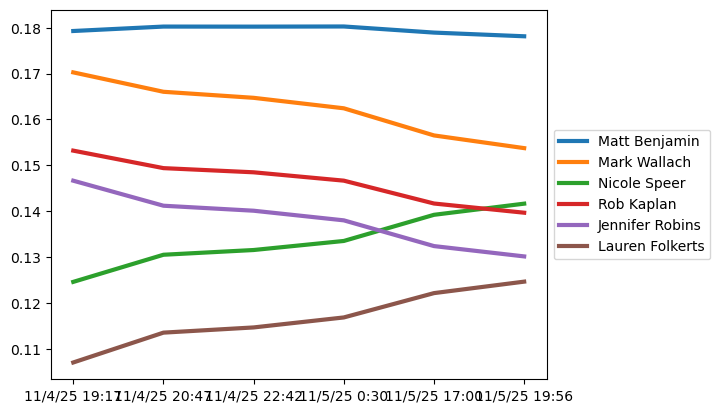

In [6]:
ax = vote_shares_df.loc[top_6].T.plot(lw=3)
ax.legend(loc='center left',bbox_to_anchor=(1,.5))

### Latest vs. first

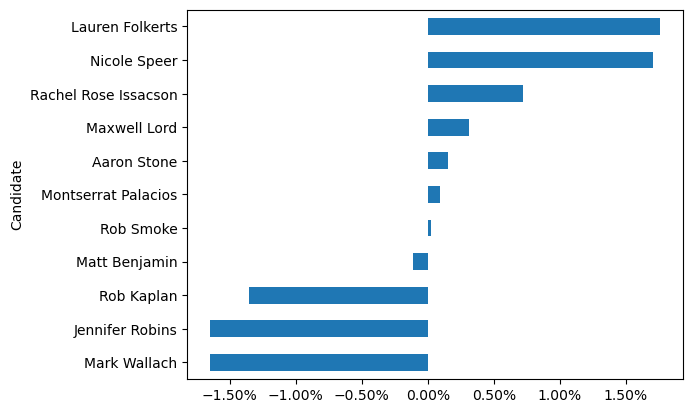

In [7]:
ax = (vote_shares_df['11/5/25 19:56'] - vote_shares_df['11/4/25 19:17']).sort_values().plot.barh()
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))

### Model

In [8]:
from scipy.stats import linregress

In [9]:
candidate_models_d = {}
model_predictions_d = {}
model_forecasts_d = {}

for candidate in vote_shares_df.index:
    model = linregress(results_2a_df['Ballots'].values,vote_shares_df.loc[candidate].values)
    candidate_models_d[candidate] = model
    model_predictions_d[candidate] = model.slope*results_2a_df['Ballots'] + model.intercept
    model_forecasts_d[candidate] = model.slope*34500 + model.intercept

model_predictions_df = pd.concat(model_predictions_d).unstack(1)
model_predictions_df

Results,11/4/25 19:17,11/4/25 20:47,11/4/25 22:42,11/5/25 0:30,11/5/25 17:00,11/5/25 19:56
Nicole Speer,0.123760,0.131062,0.131959,0.134190,0.139185,0.140782
Rob Kaplan,0.154364,0.148471,0.147746,0.145946,0.141914,0.140625
Montserrat Palacios,0.024378,0.024842,0.024899,0.025041,0.025358,0.025460
Rob Smoke,0.011796,0.011990,0.012013,0.012072,0.012205,0.012247
Maxwell Lord,0.021673,0.023064,0.023235,0.023660,0.024612,0.024916
Jennifer Robins,0.147571,0.140445,0.139568,0.137391,0.132516,0.130957
Aaron Stone,0.021583,0.022296,0.022383,0.022601,0.023088,0.023244
Lauren Folkerts,0.106454,0.113955,0.114877,0.117169,0.122300,0.123941
Mark Wallach,0.171847,0.164679,0.163798,0.161608,0.156704,0.155136
Matt Benjamin,0.180233,0.179713,0.179649,0.179490,0.179133,0.179019


### Forecast

Text(0.5, 1.0, 'Forecasted vote shares at 34,500 votes')

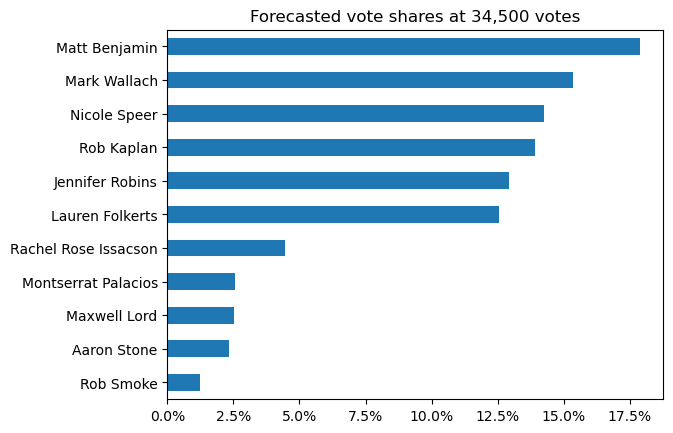

In [10]:
forecast_s = pd.Series(model_forecasts_d)

ax = forecast_s.sort_values(ascending=True).plot.barh()
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_title("Forecasted vote shares at 34,500 votes")

### Cumulative error

<Axes: >

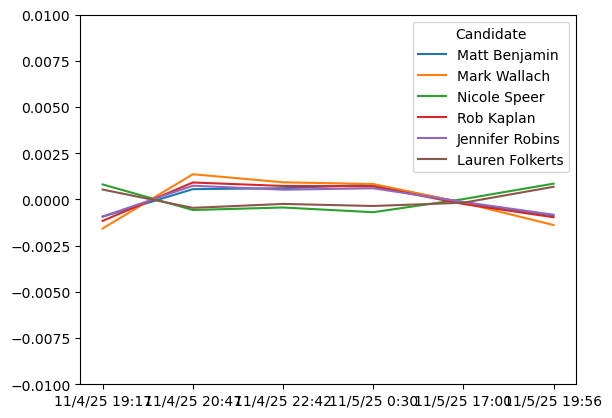

In [11]:
(vote_shares_df - model_predictions_df).loc[top_6].T.plot(ylim=(-.01,.01))

In [12]:
cuml_error_d = {}

for candidate in vote_shares_df.index:
    cuml_error_d[candidate] = {}
    for i in range(1,6):
        model = linregress(results_2a_df['Ballots'].iloc[:i+1],vote_shares_df.loc[candidate].iloc[:i+1])
        prediction = model.slope*34500 + model.intercept
        cuml_error_d[candidate][i] = model_predictions_df.loc[candidate].iloc[i] - prediction

<Axes: >

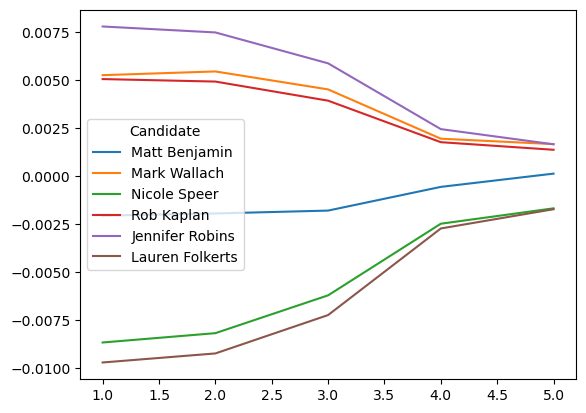

In [13]:
pd.DataFrame(cuml_error_d).loc[:,top_6].plot()